In [1]:
pip install opendatasets

In [2]:
#=================================
# Step-1: import libraries
#=================================


import warnings
warnings.filterwarnings('ignore')

import opendatasets as od
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.metrics import Precision,Recall

In [4]:
#==============================================
# step-2: file Download
#=============================================

od.download('https://www.kaggle.com/datasets/ambarish/breakhis')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chancahalsaha7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis


100%|██████████| 3.99G/3.99G [00:51<00:00, 83.1MB/s]

In [5]:
#=========================================
# Step-3: file access
#=========================================
for dirname,_,filenames in os.walk('/content/breakhis/BreaKHis_v1'):
  for file_ in filenames:
    print(os.path.join(dirname,file_))

/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/ductal_carcinoma.stat.txt.SOB
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/ductal_carcinoma.stat.txt
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/mucinous_carcinoma.stat.txt
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/lobular_carcinoma.stat.txt
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/papillary_carcinoma.stat.txt
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/process_db_stat.py
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X/SOB_M_MC-14-13418DE-200-006.png
/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malig

In [6]:
#==========================================================
# Step-4: Create DataFrame using path , label, main_calss
#===========================================================

dirname='/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/'
pattern=os.path.join(dirname,'**','*.png')

filepaths=glob.glob(pattern,recursive=True)

df=pd.DataFrame({
    'path':filepaths,
    'label':[ os.path.basename(file_).split('_')[2].split('-')[0] for file_ in filepaths],
    'main_class':[os.path.basename(file_).split('_')[1] for file_ in filepaths]
})

In [7]:
df

,path,label,main_class
0,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,MC,M
1,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,MC,M
2,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,MC,M
3,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,MC,M
4,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,MC,M
...,...,...,...
7904,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,TA,B
7905,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,TA,B
7906,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,TA,B
7907,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,TA,B


In [8]:
#==========================================================
# Step-5: split Train-test
#==========================================================

train_df,val_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df['main_class'])


In [9]:
#======================================
# Step-6: Image preprocessing
#======================================

train_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

val_gen=ImageDataGenerator(
    rescale=1./255
)

In [10]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=42

In [11]:
train_image=train_gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    seed=SEED,
    class_mode='categorical'
)

Found 6327 validated image filenames belonging to 8 classes.


In [12]:
train_image.class_indices

{'A': 0, 'DC': 1, 'F': 2, 'LC': 3, 'MC': 4, 'PC': 5, 'PT': 6, 'TA': 7}

In [13]:
val_image=val_gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    seed=SEED,
    class_mode='categorical',
    shuffle=False
)

Found 1582 validated image filenames belonging to 8 classes.


In [14]:
val_image.class_indices

{'A': 0, 'DC': 1, 'F': 2, 'LC': 3, 'MC': 4, 'PC': 5, 'PT': 6, 'TA': 7}

In [15]:
#======================================
# Step-7: Model Build
#=====================================

In [16]:

base_model=VGG16(weights='imagenet',include_top=False,input_shape=IMG_SIZE+(3,))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
base_model.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256)(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
Output=Dense(8,activation='softmax')(x)

model=Model(base_model.input,Output)

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',Precision(),Recall()]
)

In [27]:
lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    min_lr=1e-7,
    patience=3,
    verbose=1
)

er=EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
ck=ModelCheckpoint(
    f'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)


In [28]:
h=model.fit(
    train_image,
    validation_data=val_image,
    epochs=10,
    callbacks=[er,lr,ck],
    verbose=1
)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.2910 - loss: 2.1526 - precision_2: 0.3836 - recall_2: 0.1601
Epoch 1: val_accuracy improved from -inf to 0.50126, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 173s 854ms/step - accuracy: 0.2914 - loss: 2.1510 - precision_2: 0.3843 - recall_2: 0.1605 - val_accuracy: 0.5013 - val_loss: 1.3373 - val_precision_2: 0.6394 - val_recall_2: 0.4001 - learning_rate: 0.0010
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.4986 - loss: 1.4643 - precision_2: 0.6183 - recall_2: 0.3611
Epoch 2: val_accuracy improved from 0.50126 to 0.53603, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 166s 840ms/step - accuracy: 0.4987 - loss: 1.4640 - precision_2: 0.6185 - recall_2: 0.3611 - val_accuracy: 0.5360 - val_loss: 1.3870 - val_precision_2: 0.5809 - val_recall_2: 0.5063 - learning_rate: 0.0010
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.5430 - loss: 1.2970 - precision_2: 0.6652 - recall_2: 0.4076
Epoch 3: val_accuracy improved from 0.53603 to 0.57080, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 167s 841ms/step - accuracy: 0.5430 - loss: 1.2971 - precision_2: 0.6651 - recall_2: 0.4076 - val_accuracy: 0.5708 - val_loss: 1.2306 - val_precision_2: 0.6604 - val_recall_2: 0.4893 - learning_rate: 0.0010
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.5503 - loss: 1.2613 - precision_2: 0.6691 - recall_2: 0.4049
Epoch 4: val_accuracy improved from 0.57080 to 0.58597, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 175s 882ms/step - accuracy: 0.5503 - loss: 1.2613 - precision_2: 0.6691 - recall_2: 0.4049 - val_accuracy: 0.5860 - val_loss: 1.1631 - val_precision_2: 0.6801 - val_recall_2: 0.5107 - learning_rate: 0.0010
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.5746 - loss: 1.2174 - precision_2: 0.6930 - recall_2: 0.4270
Epoch 5: val_accuracy improved from 0.58597 to 0.61252, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 178s 897ms/step - accuracy: 0.5746 - loss: 1.2174 - precision_2: 0.6930 - recall_2: 0.4270 - val_accuracy: 0.6125 - val_loss: 1.0953 - val_precision_2: 0.7480 - val_recall_2: 0.4128 - learning_rate: 0.0010
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.5825 - loss: 1.1909 - precision_2: 0.7007 - recall_2: 0.4325
Epoch 6: val_accuracy did not improve from 0.61252
198/198 ━━━━━━━━━━━━━━━━━━━━ 169s 855ms/step - accuracy: 0.5825 - loss: 1.1909 - precision_2: 0.7007 - recall_2: 0.4325 - val_accuracy: 0.6087 - val_loss: 1.1432 - val_precision_2: 0.6878 - val_recall_2: 0.5082 - learning_rate: 0.0010
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.5867 - loss: 1.1642 - precision_2: 0.7020 - recall_2: 0.4430
Epoch 7: val_accuracy did not improve from 0.61252
198/198 ━━━━━━━━━━━━━━━━━━━━ 166s 840ms/step - accuracy: 0.5866 - loss: 1.1642 - precision_2: 0.7019 - recall_2: 0.4430 - val_accuracy: 0.5594 - val_loss: 1.2175 - val_pr

In [30]:
base_model.trainable=True

for layer in model.layers[:-30]:
  layer.trainable=False

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy',Precision(),Recall()]
)

In [33]:
history=model.fit(
    train_image,
    validation_data=val_image,
    epochs=15,
    callbacks=[er,lr,ck],
    verbose=1
)

Epoch 1/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6132 - loss: 1.1120 - precision_3: 0.7007 - recall_3: 0.4891
Epoch 1: val_accuracy improved from 0.61252 to 0.68331, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.6132 - loss: 1.1118 - precision_3: 0.7008 - recall_3: 0.4892 - val_accuracy: 0.6833 - val_loss: 0.8368 - val_precision_3: 0.7428 - val_recall_3: 0.6315 - learning_rate: 1.0000e-05
Epoch 2/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.6695 - loss: 0.8951 - precision_3: 0.7570 - recall_3: 0.5795
Epoch 2: val_accuracy improved from 0.68331 to 0.73135, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 189s 953ms/step - accuracy: 0.6696 - loss: 0.8948 - precision_3: 0.7570 - recall_3: 0.5796 - val_accuracy: 0.7314 - val_loss: 0.7255 - val_precision_3: 0.7719 - val_recall_3: 0.6802 - learning_rate: 1.0000e-05
Epoch 3/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.7336 - loss: 0.7411 - precision_3: 0.7993 - recall_3: 0.6543
Epoch 3: val_accuracy improved from 0.73135 to 0.76233, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 192s 969ms/step - accuracy: 0.7336 - loss: 0.7409 - precision_3: 0.7994 - recall_3: 0.6544 - val_accuracy: 0.7623 - val_loss: 0.6385 - val_precision_3: 0.8072 - val_recall_3: 0.7092 - learning_rate: 1.0000e-05
Epoch 4/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.7684 - loss: 0.6256 - precision_3: 0.8219 - recall_3: 0.7099
Epoch 4: val_accuracy improved from 0.76233 to 0.79520, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 191s 964ms/step - accuracy: 0.7684 - loss: 0.6255 - precision_3: 0.8220 - recall_3: 0.7099 - val_accuracy: 0.7952 - val_loss: 0.5716 - val_precision_3: 0.8243 - val_recall_3: 0.7592 - learning_rate: 1.0000e-05
Epoch 5/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.8124 - loss: 0.5265 - precision_3: 0.8539 - recall_3: 0.7575
Epoch 5: val_accuracy improved from 0.79520 to 0.79836, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 193s 970ms/step - accuracy: 0.8124 - loss: 0.5264 - precision_3: 0.8539 - recall_3: 0.7575 - val_accuracy: 0.7984 - val_loss: 0.5487 - val_precision_3: 0.8159 - val_recall_3: 0.7762 - learning_rate: 1.0000e-05
Epoch 6/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.8339 - loss: 0.4594 - precision_3: 0.8627 - recall_3: 0.7937
Epoch 6: val_accuracy improved from 0.79836 to 0.82617, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 193s 971ms/step - accuracy: 0.8338 - loss: 0.4594 - precision_3: 0.8627 - recall_3: 0.7937 - val_accuracy: 0.8262 - val_loss: 0.4678 - val_precision_3: 0.8478 - val_recall_3: 0.8028 - learning_rate: 1.0000e-05
Epoch 7/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.8479 - loss: 0.4206 - precision_3: 0.8823 - recall_3: 0.8157
Epoch 7: val_accuracy improved from 0.82617 to 0.84513, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 192s 970ms/step - accuracy: 0.8480 - loss: 0.4206 - precision_3: 0.8823 - recall_3: 0.8157 - val_accuracy: 0.8451 - val_loss: 0.4235 - val_precision_3: 0.8657 - val_recall_3: 0.8274 - learning_rate: 1.0000e-05
Epoch 8/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.8640 - loss: 0.3797 - precision_3: 0.8914 - recall_3: 0.8316
Epoch 8: val_accuracy improved from 0.84513 to 0.85525, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 191s 962ms/step - accuracy: 0.8640 - loss: 0.3796 - precision_3: 0.8914 - recall_3: 0.8316 - val_accuracy: 0.8552 - val_loss: 0.3828 - val_precision_3: 0.8734 - val_recall_3: 0.8413 - learning_rate: 1.0000e-05
Epoch 9/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.8752 - loss: 0.3501 - precision_3: 0.8968 - recall_3: 0.8492
Epoch 9: val_accuracy did not improve from 0.85525
198/198 ━━━━━━━━━━━━━━━━━━━━ 189s 954ms/step - accuracy: 0.8752 - loss: 0.3500 - precision_3: 0.8968 - recall_3: 0.8493 - val_accuracy: 0.8357 - val_loss: 0.4484 - val_precision_3: 0.8530 - val_recall_3: 0.8180 - learning_rate: 1.0000e-05
Epoch 10/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.8955 - loss: 0.3014 - precision_3: 0.9128 - recall_3: 0.8693
Epoch 10: val_accuracy improved from 0.85525 to 0.85841, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 189s 956ms/step - accuracy: 0.8955 - loss: 0.3014 - precision_3: 0.9128 - recall_3: 0.8694 - val_accuracy: 0.8584 - val_loss: 0.3752 - val_precision_3: 0.8753 - val_recall_3: 0.8477 - learning_rate: 1.0000e-05
Epoch 11/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.9150 - loss: 0.2514 - precision_3: 0.9277 - recall_3: 0.8983
Epoch 11: val_accuracy did not improve from 0.85841
198/198 ━━━━━━━━━━━━━━━━━━━━ 189s 954ms/step - accuracy: 0.9149 - loss: 0.2515 - precision_3: 0.9277 - recall_3: 0.8982 - val_accuracy: 0.8496 - val_loss: 0.3826 - val_precision_3: 0.8642 - val_recall_3: 0.8369 - learning_rate: 1.0000e-05
Epoch 12/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.9092 - loss: 0.2573 - precision_3: 0.9207 - recall_3: 0.8867
Epoch 12: val_accuracy did not improve from 0.85841
198/198 ━━━━━━━━━━━━━━━━━━━━ 188s 950ms/step - accuracy: 0.9092 - loss: 0.2573 - precision_3: 0.9207 - recall_3: 0.8867 - val_accuracy: 0.8496 - val_loss: 0.4

198/198 ━━━━━━━━━━━━━━━━━━━━ 193s 973ms/step - accuracy: 0.9233 - loss: 0.2329 - precision_3: 0.9335 - recall_3: 0.9104 - val_accuracy: 0.8774 - val_loss: 0.3365 - val_precision_3: 0.8839 - val_recall_3: 0.8666 - learning_rate: 1.0000e-05
Epoch 14/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.9334 - loss: 0.1997 - precision_3: 0.9406 - recall_3: 0.9192
Epoch 14: val_accuracy did not improve from 0.87737
198/198 ━━━━━━━━━━━━━━━━━━━━ 188s 947ms/step - accuracy: 0.9334 - loss: 0.1998 - precision_3: 0.9406 - recall_3: 0.9192 - val_accuracy: 0.8710 - val_loss: 0.3841 - val_precision_3: 0.8811 - val_recall_3: 0.8571 - learning_rate: 1.0000e-05
Epoch 15/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9388 - loss: 0.1814 - precision_3: 0.9454 - recall_3: 0.9269
Epoch 15: val_accuracy did not improve from 0.87737
198/198 ━━━━━━━━━━━━━━━━━━━━ 189s 953ms/step - accuracy: 0.9388 - loss: 0.1814 - precision_3: 0.9453 - recall_3: 0.9268 - val_accuracy: 0.8527 - val_loss: 0.3

In [34]:
#=====================================
# Step- : Evaluation
#====================================

loss,acc,pre,recall=model.evaluate(val_image)

print(f'Accuracy: {acc*100:.2f}%')
print(f'Loss: {loss*100:.2f}%')
print(f'Precision: {pre*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.8829 - loss: 0.3153 - precision_3: 0.8909 - recall_3: 0.8749
Accuracy: 87.74%
Loss: 33.65%
Precision: 88.39%
Recall: 86.66%


In [39]:

label=val_image.class_indices
label

{'A': 0, 'DC': 1, 'F': 2, 'LC': 3, 'MC': 4, 'PC': 5, 'PT': 6, 'TA': 7}

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

val_image.reset()

y_pred=model.predict(val_image,verbose=0)

y_pred_label=np.argmax(y_pred,axis=1)
cm=confusion_matrix(val_image.classes,y_pred_label)



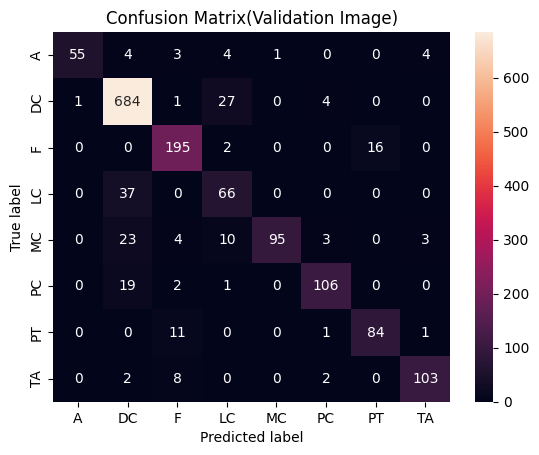

In [46]:
sns.heatmap(cm,annot=True,fmt='d',xticklabels=label,yticklabels=label)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix(Validation Image)')
plt.show()

In [49]:
val_image.reset()

cl=classification_report(val_image.classes,y_pred_label,target_names=label)
print(cl)

              precision    recall  f1-score   support

           A       0.98      0.77      0.87        71
          DC       0.89      0.95      0.92       717
           F       0.87      0.92      0.89       213
          LC       0.60      0.64      0.62       103
          MC       0.99      0.69      0.81       138
          PC       0.91      0.83      0.87       128
          PT       0.84      0.87      0.85        97
          TA       0.93      0.90      0.91       115

    accuracy                           0.88      1582
   macro avg       0.88      0.82      0.84      1582
weighted avg       0.88      0.88      0.88      1582

